In [1]:
import logging, os, sys
import numpy as np
import urllib.request
import shutil
import subprocess
import zipfile
import pickle
from pathlib import Path
import pandas as pd
from Pegasus.api import *

from util_workflow import add_input_wf_files,create_file_objects
from util_workflow import download_data, unzip_flatten_data, return_corrupted_files, return_input_files
from util_workflow import split_data_filenames, add_input_tune_model,create_tar_and_pkl, create_pkl

In [2]:
# --- Import Pegasus API ---
from Pegasus.api import *
logging.basicConfig(level=logging.DEBUG)
props = Properties()
props["dagman.retry"] = "2"
props["pegasus.transfer.arguments"] = "-m 1"
props.write()

dataset_link = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip"
zip_data = "kagglecatsanddogs_3367a.zip"
directory_to_extract_to = "."

DOWNLOAD_DATA = False
DATASET_SIZE = 12
DATA_DIR = "dev_data/"
UTILS_DIR = "utils/"

arch_names = ["basicnet", "densenet121", "vgg16"]
CATS = "PetImages/Cat"
DOGS = "PetImages/Dog"
LABELS = {CATS: 0, DOGS: 1}
NUM_EPOCHS = 4
NUM_TRIALS = 3
NUM_WORKERS = 8
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)   
    
if DOWNLOAD_DATA == True:
    download_data(dataset_link)

In [3]:
# Avoid corrupted files for now
corrupted_files = return_corrupted_files("corrupted_files.txt")
# Get names of image files that will serve as inputs to the workflow
input_file_names = return_input_files(corrupted_files, DATASET_SIZE, DATA_DIR, LABELS)


#train 70%, val 10% and test 20%
train_filenames,val_filenames,test_filenames, files_split_dict = split_data_filenames(input_file_names)

workers_ids = [x for x in range(NUM_WORKERS)]
train_workers, val_workers, test_workers, _ = split_data_filenames(workers_ids)
num_train_workers, num_val_workers, num_test_workers, = len(train_workers), len(val_workers), len(test_workers)

In [4]:
rc = ReplicaCatalog()

# TRAIN, VAL and TEST data are processed separately
input_preprocess1_train = add_input_wf_files(train_filenames, DATA_DIR,rc)
input_preprocess1_val   = add_input_wf_files(val_filenames, DATA_DIR,rc)
input_preprocess1_test  = add_input_wf_files(test_filenames, DATA_DIR,rc)
rc.write()

In [5]:
# Create and add our transformations to the TransformationCatalog.
tc = TransformationCatalog()

# Data preprocessing part 1 
preprocess_tc1 = Transformation(
                "preprocess1",
                site="local",
                pfn = str(Path(".").parent.resolve() / "bin/data_preprocessing1.py"), 
                is_stageable= True
            )

# Data preprocessing part 1 
preprocess_tc2 = Transformation(
                "preprocess2",
                site="local",
                pfn = str(Path(".").parent.resolve() / "bin/data_preprocessing2_arg.py"), 
               is_stageable= True
            )

tc.add_transformations(preprocess_tc1, preprocess_tc2)#tune_model_vgg16,choose_best_model)
tc.write()

In [6]:
# create the preproces jobs
preprocess1_jobs_train = [Job(preprocess_tc1) for i in range(num_train_workers)]
preprocess1_jobs_val   = [Job(preprocess_tc1) for i in range(num_val_workers)]
preprocess1_jobs_test  = [Job(preprocess_tc1) for i in range(num_test_workers)]

In [7]:
def add_job_attributes_1to1(jobs_list, input_files,postfix):
    output_files = []
    for i in range(len(input_files)):
        curr = i % len(jobs_list)
        jobs_list[curr].add_inputs(File(input_files[i]))
        outfile = input_files[i].split(".")[0] + postfix
        output_files.append(outfile)
        jobs_list[curr].add_outputs(File(outfile))
    return jobs_list,output_files

In [8]:
# Create FILE objects with correct postfixes
postfix_job1 = "_proc1.jpg"
preprocess1_jobs_train, output_preprocess1_train = add_job_attributes_1to1(preprocess1_jobs_train, \
                                                                           train_filenames, postfix_job1)
preprocess1_jobs_val, output_preprocess1_val = add_job_attributes_1to1(preprocess1_jobs_val,\
                                                                          val_filenames, postfix_job1)
preprocess1_jobs_test,output_preprocess1_test = add_job_attributes_1to1(preprocess1_jobs_test,\
                                                                          test_filenames, postfix_job1)

In [9]:
preprocess2_jobs_train = [Job(preprocess_tc2).add_args("train") for i in range(num_train_workers)]
preprocess2_jobs_val   = [Job(preprocess_tc2).add_args("val") for i in range(num_val_workers)]
preprocess2_jobs_test  = [Job(preprocess_tc2).add_args("test") for i in range(num_test_workers)]

In [10]:
def add_job_attributes_1torange(jobs_list, input_files,range_num,dataset,old_postfix,new_postfix):
    output_files = []
    for i in range(len(input_files)):
        curr = i % len(jobs_list)
        jobs_list[curr].add_inputs(File(input_files[i]))
        for j in range(range_num):
            fname = dataset + input_files[i].split(old_postfix)[0]+ new_postfix + str(j)+ ".jpg"
            output_files.append(fname)
            jobs_list[curr].add_outputs(File(fname))
    return jobs_list,output_files  

In [11]:
range_num = 4
postfix_job2 = "_proc2_"

preprocess2_jobs_train,output_preprocess2_train = add_job_attributes_1torange(preprocess2_jobs_train,\
                                                                          output_preprocess1_train,\
                                                                          range_num, "train_",\
                                                                          postfix_job1,postfix_job2)

preprocess2_jobs_val,output_preprocess2_val  = add_job_attributes_1torange(preprocess2_jobs_val,\
                                                                           output_preprocess1_val,\
                                                                           range_num, "val_",\
                                                                           postfix_job1,postfix_job2)

preprocess2_jobs_test,output_preprocess2_test = add_job_attributes_1torange(preprocess2_jobs_test,\
                                                                         output_preprocess1_test,\
                                                                         range_num, "test_",\
                                                                         postfix_job1,postfix_job2)

In [12]:
# Set infer_dependencies=True so that they are inferred based on job input and output file usage.
wf = Workflow("catVsdog-test-wf", infer_dependencies=True)
wf.add_jobs(*preprocess1_jobs_train,*preprocess1_jobs_val,*preprocess1_jobs_test,\
            *preprocess2_jobs_train,*preprocess2_jobs_val, *preprocess2_jobs_test )


In [13]:
try:
    wf.plan(submit=True)\
    .wait()\
    .analyze()\
    .statistics()
except PegasusClientError as e:
    print(e.output)


################
# pegasus-plan #
################
2021.02.11 06:34:37.884 UTC:
2021.02.11 06:34:37.889 UTC:   -----------------------------------------------------------------------
2021.02.11 06:34:37.894 UTC:   File for submitting this DAG to HTCondor           : catVsdog-test-wf-0.dag.condor.sub
2021.02.11 06:34:37.899 UTC:   Log of DAGMan debugging messages                 : catVsdog-test-wf-0.dag.dagman.out
2021.02.11 06:34:37.904 UTC:   Log of HTCondor library output                     : catVsdog-test-wf-0.dag.lib.out
2021.02.11 06:34:37.909 UTC:   Log of HTCondor library error messages             : catVsdog-test-wf-0.dag.lib.err
2021.02.11 06:34:37.915 UTC:   Log of the life of condor_dagman itself          : catVsdog-test-wf-0.dag.dagman.log
2021.02.11 06:34:37.920 UTC:
2021.02.11 06:34:37.925 UTC:   -no_submit given, not submitting DAG to HTCondor.  You can do this with:
2021.02.11 06:34:37.935 UTC:   -----------------------------------------------------------------------


[####################################] 100.0% ..Success (Completed: 30, Queued: 0, Running: 0, Failed: 0))



####################
# pegasus-analyzer #
####################
Your database is compatible with Pegasus version: 5.1.0dev

************************************Summary*************************************

Submit Directory   : /home/scitech/shared-data/pegasus-catdog-wf-master/scitech/pegasus/catVsdog-test-wf/run0007
Total jobs         :     30 (100.00%)
# jobs succeeded   :     30 (100.00%)
# jobs failed      :      0 (0.00%)
# jobs held        :      0 (0.00%)
# jobs unsubmitted :      0 (0.00%)


######################
# pegasus-statistics #
######################
Your database is compatible with Pegasus version: 5.1.0dev

#
# Pegasus Workflow Management System - http://pegasus.isi.edu
#
# Workflow summary:
#   Summary of the workflow execution. It shows total
#   tasks/jobs/sub workflows run, how many succeeded/failed etc.
#   In case of hierarchical workflow the calculation shows the
#   statistics across all the sub workflows.It shows the following
#   statistics about tasks, job

In [14]:
wf.graph(include_files=True, no_simplify=True, label="xform-id", output="graph_2prejobs.dot")


####################
# pegasus-graphviz #
####################


In [15]:
#! sudo yum install graphviz -y
#! cat graph.dot
#! dot -Tpng graph.dot -o graph.png

In [16]:
#! cat graph.dot

In [17]:
! dot -Tpng graph_2prejobs.dot -o graph_2prejobs.png

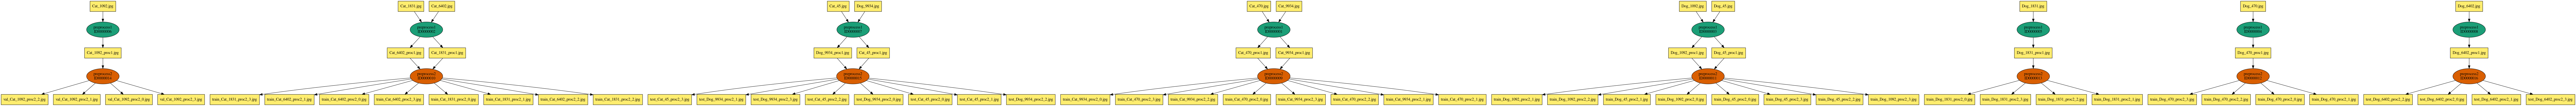

In [18]:
from IPython.display import Image
Image(filename='graph_2prejobs.png')